# Tranist Detection

In this tutorial, we will show you how to use Deep-Transit to find transiting signals in detail.

## Prepare Models

We have released two pretrained models, one is trained from Kepler data, you can download it from [here](http://paperdata.china-vo.org/ckm/model_Kepler.pth).
The other one is a model trained on TESS data using transfer learning methods, you can download it from [here](http://paperdata.china-vo.org/ckm/model_TESS.pth). (Note: each model is around 200 MB.)

You can also train your own model from your own data set. Please check our documentation of [Train your own model](Train.ipynb).

make sure the path of your model:

In [1]:
model_path = '/home/ckm/model_Kepler.pth'

## Prepare Light Curves

We highly recommend to use ``Lightkurve`` package and create a lightcurve object, though we also support the raw time, flux, and flux_error data in array-like format.

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

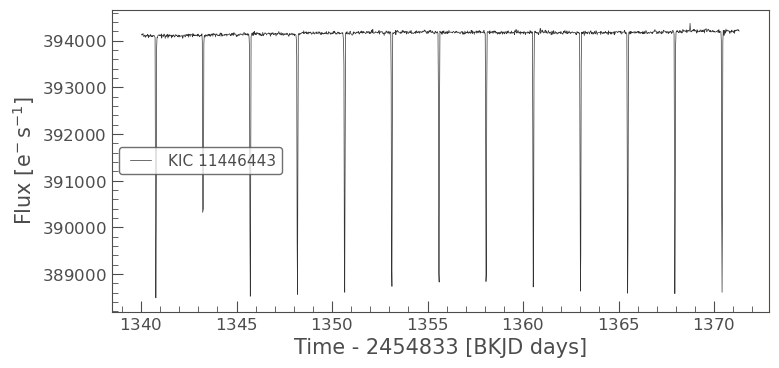

In [2]:
import lightkurve as lk
lc = lk.search_lightcurve('Kepler-1b', quarter=14, exptime='long').download();
lc = lc[lc.time.value>1340] # To save computating time
lc.plot()

## Detection

The detection method is implemented as a function of ``deep_transit.DeepTransit`` class, so the first step is pass your light curve to the class to create an instance of ``deep_transit.DeepTransit``.

The ``DeepTransit`` receive a lightcurve object and use a keyword `is_flat` to determine whether to use the built-in flatten method.
If the input light curve is already detrended, or the light curve trend can be ignored compared with transit signals, the `is_flat` should be False, otherwise you need to make the `is_flat` to False.

The flatten method is the Tukey’s biweight algorithm implemented by [Wōtan](https://github.com/hippke/wotan).
You can modify the default parameters of flatten method through passing keys and values to `flatten_kwargs`.

In [3]:
import deep_transit as dt
dt_obj = dt.DeepTransit(lc, is_flat=False)

Then, the transit detection can be done with the ``transit_detection`` function.
Some parameters can be modified depending on the task and your computational environment.

For example, the `confidence_threshold` can be adjusted according your project, higher confidence threshold yields higher precision, lower confidence threshold yields higher recall. If you have an Nvidia GPU with CUDA installed on your system, the `device_str` can be specified to "cuda".
We have two optional backends, the default is PyTorch, one can also choose the MegEngine by setting backend to "megengine".

In [4]:
bboxes = dt_obj.transit_detection(model_path, batch_size=2, confidence_threshold=0.6, nms_iou_threshold=0.1, device_str='auto', backend='pytorch')

Loading Model: /home/ckm/model_Kepler.pth


/home/ckm/Deep-Transit/src/deep_transit/dt_lightcurve.py:317: UserWarning: The total number of progress bar is the upper limit.
100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


The returned bboxes is an numpy.ndarray of bounding boxes. You can plot them with the light curve.

Note: if you choose `is_falt=False`, the light curve for plotting should be the detrended light curve.
You need to manually obtain the detrended light curve by using `detrend_light_curve` method.

<AxesSubplot:xlabel='Time (day)', ylabel='Normalized Flux'>

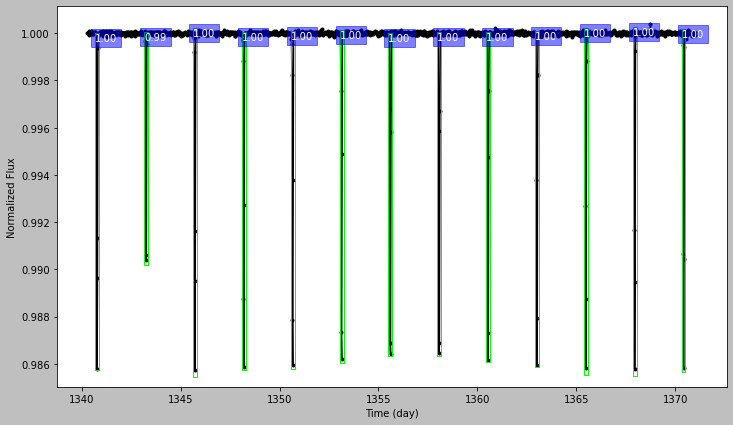

In [5]:
detrended_lc = dt.detrend_light_curve(lc)
dt.plot_lc_with_bboxes(detrended_lc, bboxes, ms=3, marker='o')

## Use TESS model on Pi Mensae

Now, let's try our pretrained TESS model on Pi Mensae, which is the first confirmed transiting exoplanet of TESS.

In [6]:
lc = lk.search_lightcurve('Pi Mensae', mission='TESS', sector=1, author='spoc').download()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

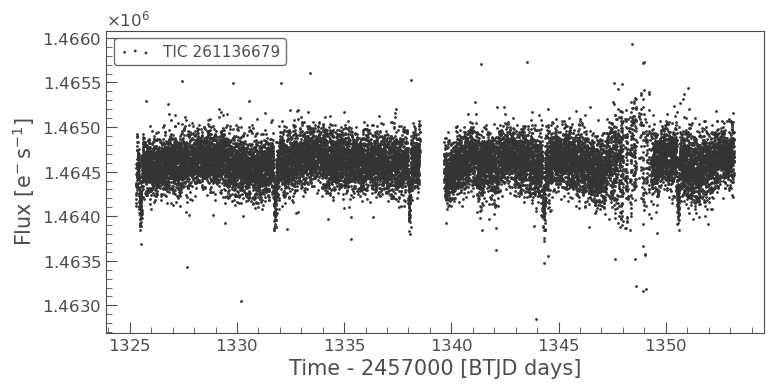

In [7]:
lc.scatter()

In [8]:
model_path = '/home/ckm/model_TESS.pth'

In [9]:
import deep_transit as dt
bboxes = dt.DeepTransit(lc).transit_detection(model_path, confidence_threshold=0.8)

Loading Model: /home/ckm/model_TESS.pth


/home/ckm/Deep-Transit/src/deep_transit/dt_lightcurve.py:317: UserWarning: The total number of progress bar is the upper limit.
100%|██████████| 2/2 [00:24<00:00, 12.46s/it]


<AxesSubplot:xlabel='Time (day)', ylabel='Normalized Flux'>

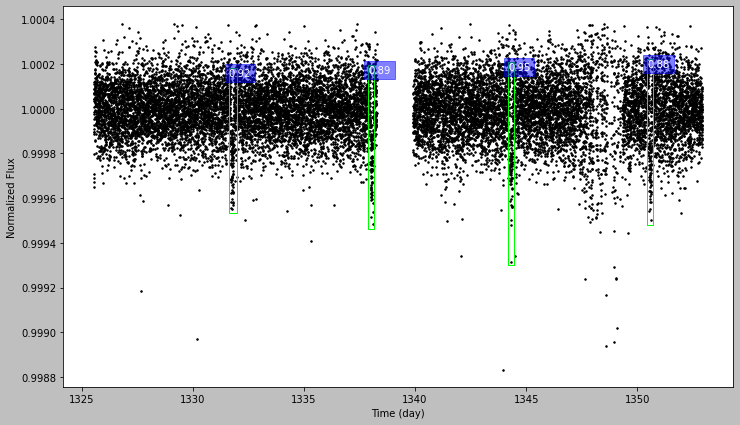

In [10]:
detrended_lc = dt.detrend_light_curve(lc)
dt.plot_lc_with_bboxes(detrended_lc, bboxes, ms=3, marker='.', lw=0)